# Initialisation

To install quosc locally (so that you can edit the code), navigate to the outer directory `quosc` in terminal and run `pip install -e .`. This will install the package in editable mode. You may need to restart the kernel for any changes to be registered. Otherwise, run the below command:

In [1]:
%pip install --upgrade quosc

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quosc as qo

# Importing energy bands

The code takes in a 4-dimensional energy array with shape $(N_{\text{bands}}, N_{a^\star}, N_{b^\star}, N_{c^\star})$, which describes the energies in the Brillouin zone as follows:
- $N_{\text{bands}}$ is the number of bands
- $N_{a^\star}$ is the number of k-points along the first reciprocal lattice vector $\mathbf{a^\star}$
- $N_{b^\star}$ is the number of k-points along the second reciprocal lattice vector $\mathbf{b^\star}$
- $N_{c^\star}$ is the number of k-points along the third reciprocal lattice vector $\mathbf{c^\star}$

For example, (recalling that Python indices start from $0$), the $[I,A,B,C]$ element of the array is the energy for the $I+1^\text{th}$ band at the $\mathbf{k}$-vector:
$$\mathbf{k} = \mathbf{k_0} + \frac{A}{N_{a^\star}} \mathbf{a^\star} + \frac{B}{N_{b^\star}} \mathbf{b^\star} + \frac{C}{N_{a^\star}} \mathbf{c^\star}$$

NB: it doesn't matter for the purposes of simulating quantum oscillations where the Brillouin zone is centred - i.e., what the value of $\mathbf{k_0}$ is.

### Option 1: Manually create bandstructure

We will first create a simple bandstructure with $2$ bands and $10 \times 10 \times 10$ k-points.

In [3]:
# lets have 10x10x10 grid within the first Brillouin zone
Na = 10
Nb = 10
Nc = 10

# now make a meshgrid (from (0,0,0) to (1,1,1))
kx = np.linspace(0, 1, Na, endpoint=False)
ky = np.linspace(0, 1, Nb, endpoint=False)
kz = np.linspace(0, 1, Nc, endpoint=False)

KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')

# now we can calculate the energy using the dispersion relation - CHANGE TO WHATEVER YOU WANT
def energy_fn(kx, ky, kz):
    """
    Energy dispersion relation (with kx, ky, kz in fractional coordinates)
    """
    return 2 * (np.cos(2 * np.pi * kx) + np.cos(2 * np.pi * ky) + np.cos(2 * np.pi * kz))

# calculate the energy
band1 = energy_fn(KX, KY, KZ)
band2 = energy_fn(KX, KY, KZ) + 3 # just adding another band for fun

# group the bands into a single numpy array
bands = np.stack([band1, band2])

Next, we have to define the Fermi energy and the reciprocal lattice vectors.

In [4]:
fermi_energy = 0.5
reciprocal_lattice = np.array([[2*np.pi, 0, 0], [0, 2*np.pi, 0], [0, 0, 2*np.pi]])

### Option 2: Import bandstructure from .skeaf file

### Option 3: Import bandstructure from interpolation.bt2 file

# Visualisation

By this stage we need:
- The energy bands (numpy array of shape $(N_{\text{bands}}, N_{a^\star}, N_{b^\star}, N_{c^\star})$)
- The Fermi energy $E_F$
- The reciprocal lattice vectors $\mathbf{a^\star}$, $\mathbf{b^\star}$, $\mathbf{c^\star}$

### Visualising bandstructure

##### Energy distribution
First, we can plot the energy distributions of the bands to identify which bands cross the Fermi energy.

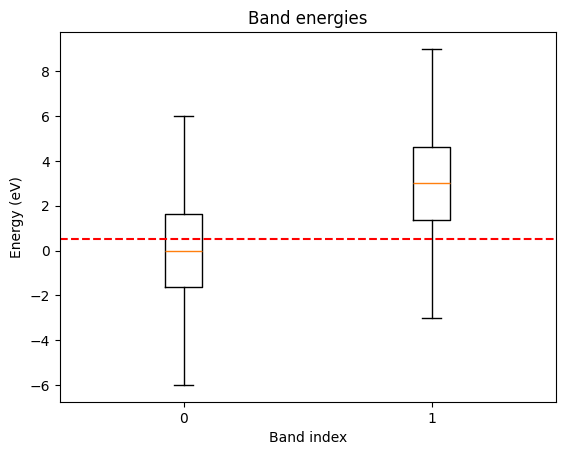

In [5]:
qo.energy_plots.plot_energy_distribution(bands, fermi_energy=fermi_energy)

##### 3D bandstructure plot

If we want we can plot the bandstructure in 3D, but note that for lots of k-points this can be slow.

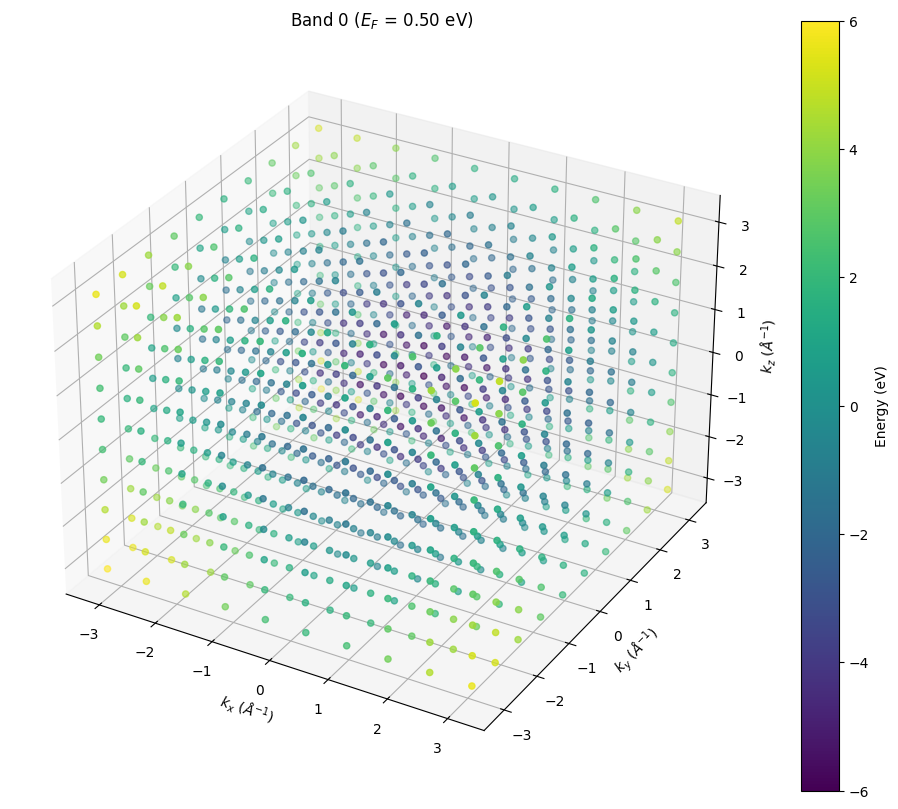

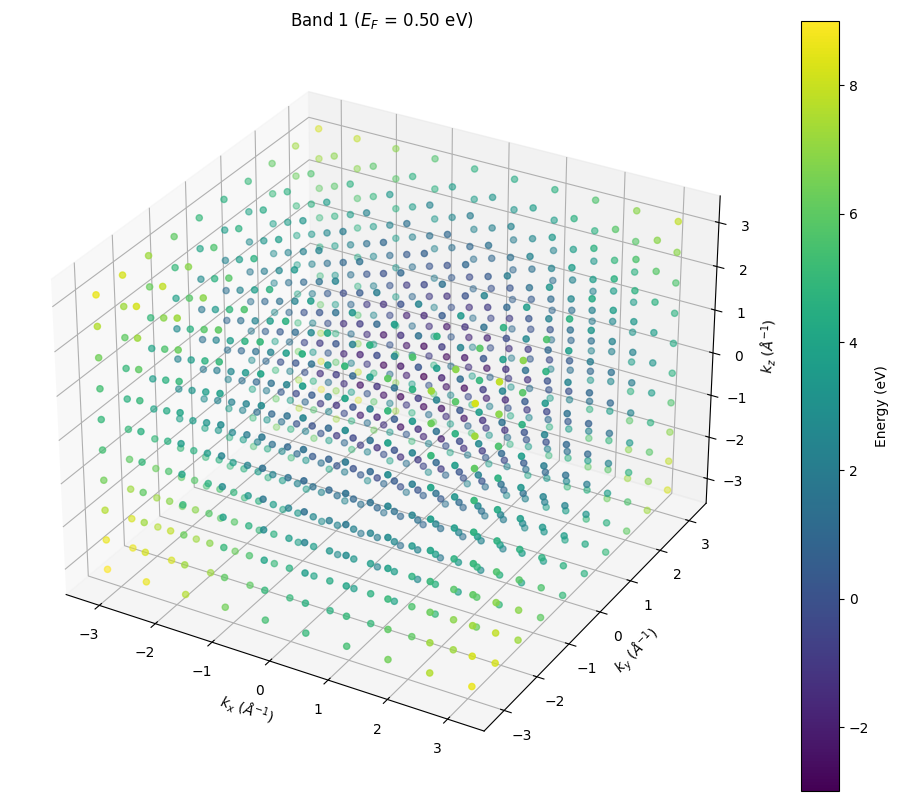

In [9]:
qo.energy_plots.plot_band_structure([0,1], energies=bands, reciprocal_lattice=reciprocal_lattice, fermi_energy=fermi_energy, figsize=(12,10))

### Fermi surface

First we tile the Brillouin zone - this helps to see pockets at the corners of the Brillouin zone. The `tiling` parameter is the number of times to tile the Brillouin zone in each direction (or we can set e.g. `tiling=(2,2,1)` to tile twice along $\mathbf{a^\star}$ and $\mathbf{b^\star}$, and once along $\mathbf{c^\star}$).

In [10]:
tiling = 3 # or e.g. (2,2,1)
endpoints_included = False # False for our manual example, True if using BoltzTraP (this is just a minor detail)

tiled_bands = qo.create_mesh.tile_mesh(bands, tiling = tiling, endpoints_included=endpoints_included)

We then create a `trimesh` object which is a 3D mesh of the Fermi surface. We can plot this mesh in 3D.

In [11]:
mesh = qo.create_mesh.create_trimesh(
    band_index = 1,
    energies_mesh = tiled_bands,
    reciprocal_lattice = reciprocal_lattice,
    fermi_energy = fermi_energy,
    tiling=tiling
)

In [12]:
mesh.show()

### Slicing Fermi surface

We choose the normal vector ($\mathbf{B}$ direction) and the heights of the slices. We can then plot the slices of the Fermi surface in 3D.

In [13]:
# choose a normal vector
normal = np.array([0,0,1])

# generate the heights to slice the mesh
heights = qo.slice_mesh.generate_heights(reciprocal_lattice, tiling=tiling, bz_divisions=20)

sections = qo.slice_mesh.calculate_sections(mesh, normal, heights)

In [14]:
# code for visualizing the sections
import trimesh
scene = trimesh.Scene()
scene.add_geometry(mesh)

for section in sections:
    if section is not None:
        scene.add_geometry(section.to_3D())
scene.show()

# Stage 1 - calculate frequencies, curvatures, masses

You need to provide the following:
- `band_energies`: the energy bands (numpy array of shape $(N_{\text{bands}}, N_{a^\star}, N_{b^\star}, N_{c^\star})$)
- `band_indices`: the band indices of the bands that cross the Fermi energy (and which you want to calculate the quantum oscillations for)
- `fermi_energy`: the Fermi energy $E_F$
- `reciprocal_lattice`: the reciprocal lattice vectors $\mathbf{a^\star}$, $\mathbf{b^\star}$, $\mathbf{c^\star}$ (in a $3 \times 3$ numpy array)
- `start_normal`: the initial normal vector from which to start the angle sweep
- `end_normal`: the final normal vector to which to sweep
- `num_points`: the number of angles to sweep between (and including) `start_normal` and `end_normal`

There are some optional extra parameters, and the option to save the results to a csv file.

The code will output a pandas dataframe with the following columns:
- `band`: the band index
- `angle`: the angle of the normal vector (from `start_normal`) in **radians**
- `frequency`: the frequency of the quantum oscillations in **T**
- `curvature`: the curvature of the Fermi surface at the extremal orbit in **T Å²**
- `effective_mass`: the effective mass of the charge carriers in **mₑ** (note that positive effective masses are electron-like, and negative effective masses are hole-like)



In [15]:
df = qo.calculate_frequencies_curvatures_masses(
    band_indices = [0,1],
    band_energies = bands,
    reciprocal_lattice = reciprocal_lattice,
    fermi_energy = fermi_energy,
    start_normal = reciprocal_lattice[2], # c*-vector
    end_normal = reciprocal_lattice[0], # a*-vector
    num_points = 16,
    save = False,
    #filename='fermi_energy.csv',
    tiling=3,
    endpoints_included=False,
    height_bz_divisions=50,
    area_grouping_tolerance=0.1,
    frequency_tolerance=0.05,
    curvature_tolerance=0.6,
)

Calculating frequencies, curvatures, and masses for 16 angles.
Step 1/3 in progress...
2 bands to process
Processed band 1/2
Processed band 2/2
Step 1/3 complete.
Step 2/3 in progress...
2 bands to process
Processed band 1/2
Processed band 2/2
Step 2/3 complete.
Step 3/3 in progress...
2 bands to process
Processed band 1/2
Processed band 2/2
Step 3/3 complete.


In [16]:
# you can inspect the output dataframe - it is a pandas dataframe so you can use all the pandas functions (and export to csv, etc.)
df.head(10)

,band,angle,frequency,curvature,count,mass
0,0,0.000000,98033.350459,238202.455562,1,5.576672
1,0,0.000000,51898.851320,199438.884878,1,-4.913695
2,0,0.104720,101859.352849,142282.585040,1,5.810121
3,0,0.104720,54216.041848,139249.140089,1,-5.062928
4,0,0.209440,107825.642288,95309.636670,1,6.283820
5,0,0.209440,57564.410411,79674.583250,1,-5.309465
6,0,0.314159,116082.389155,222781.207101,1,7.204587
7,0,0.314159,62000.965302,89151.041084,1,-5.608949
8,0,0.418879,68429.813147,194126.502217,1,-6.423938
9,0,0.523599,379858.951902,131905.457126,1,-15.402652


Below is example pandas syntax to plot different columns of the dataframe for a chosen band index.

<Axes: xlabel='angle', ylabel='frequency'>

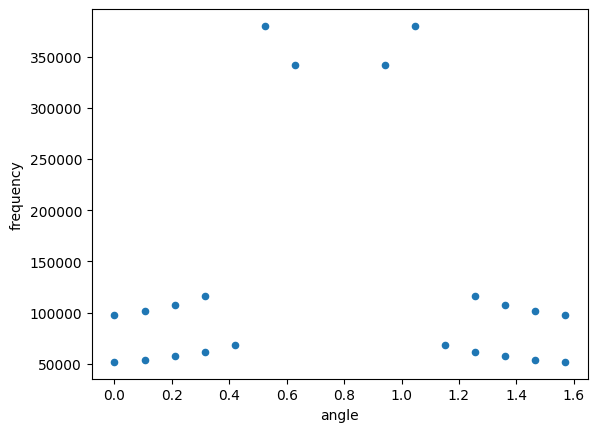

In [17]:
# plot 'frequency' vs 'angle' for each 'band' == 0
df[df['band'] == 0].plot(x='angle', y='frequency', kind='scatter')

# Stage 2 - simulate torque magnetometry

### Grouping extremal orbits across angles

With the grouping function, we can group extremal orbits that are the same across different angles. This is needed for later interpolation and to calculate a $\text{d} F / \text{d} \theta$ term.

In [18]:
# run the function
df_grouped = qo.torque_simulation.group_across_angles(
    df,
    rel_freq_tolerance=0.3,
    abs_freq_tolerance=10,
    rel_curv_tolerance=10,
    abs_curv_tolerance=10000,
    rel_mass_tolerance=0.8,
    abs_mass_tolerance=0.1,
)

df_grouped.head(10)

C:\Users\mihir\Documents\Oxford Physics\Superconductors\Python\extremal orbits\quosc\src\quosc\torque_simulation\grouping.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_band.loc[j, 'predicted_freq'] = predicted_freqs[j]
C:\Users\mihir\Documents\Oxford Physics\Superconductors\Python\extremal orbits\quosc\src\quosc\torque_simulation\grouping.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_band.loc[j, 'predicted_freq'] = predicted_freqs[j]


,band,angle,frequency,curvature,count,mass,df_dtheta,group
0,0,0.000000,98033.350459,238202.455562,1,5.576672,NaN,1.0
1,0,0.000000,51898.851320,199438.884878,1,-4.913695,NaN,2.0
2,0,0.104720,101859.352849,142282.585040,1,5.810121,27051.052044,1.0
3,0,0.104720,54216.041848,139249.140089,1,-5.062928,27051.052044,2.0
4,0,0.209440,107825.642288,95309.636670,1,6.283820,37170.271483,1.0
5,0,0.209440,57564.410411,79674.583250,1,-5.309465,37170.271483,2.0
6,0,0.314159,116082.389155,222781.207101,1,7.204587,51878.476621,1.0
7,0,0.314159,62000.965302,89151.041084,1,-5.608949,51878.476621,2.0
8,0,0.418879,68429.813147,194126.502217,1,-6.423938,NaN,2.0
9,0,0.523599,379858.951902,131905.457126,1,-15.402652,NaN,3.0


Here is an example of how to plot the frequencies coloured by the calculated groups.

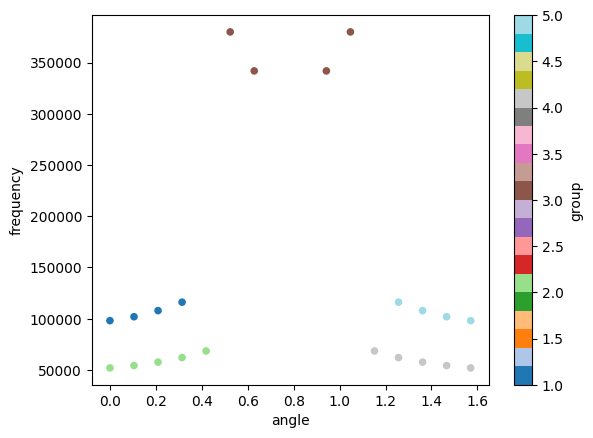

In [19]:
# plot colouring the groups
df_grouped[df_grouped['band'] == 0].plot(x='angle', y='frequency', kind='scatter', c='group', cmap='tab20');

### Interpolating within the groups

This interpolation may not be necessary to generate more angles, but it does allow for a better estimation of the $\text{d} F / \text{d} \theta$ term.

In [20]:
df_interp = qo.torque_simulation.interpolate_across_bands(df_grouped, interpolation_fineness=10)

df_interp.head(10)

C:\Users\mihir\Documents\Oxford Physics\Superconductors\Python\extremal orbits\quosc\src\quosc\torque_simulation\interpolation.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_interp_band1 = pd.concat([df_interp_band1, df_group_interp])
C:\Users\mihir\Documents\Oxford Physics\Superconductors\Python\extremal orbits\quosc\src\quosc\torque_simulation\interpolation.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_interp = pd.concat([df_interp, df_interp_band1])
C:\Users\mihir\Documents

,angle,frequency,group,band,curvature,count,mass,df_dtheta
0,0.000000,98033.350459,1.0,0,238202.455562,1,5.576672,26952.955663
1,0.001745,98080.392241,1.0,0,236882.573702,1,5.579714,27111.523285
2,0.003491,98127.987528,1.0,0,235542.008773,1,5.582767,27428.857699
3,0.005236,98176.137016,1.0,0,234181.341783,1,5.585831,27746.590453
4,0.006981,98224.841400,1.0,0,232801.153738,1,5.588907,28064.721546
5,0.008727,98274.101375,1.0,0,231402.025647,1,5.591996,28383.250978
6,0.010472,98323.917637,1.0,0,229984.538517,1,5.595099,28702.178750
7,0.012217,98374.290880,1.0,0,228549.273355,1,5.598218,29021.504860
8,0.013963,98425.221799,1.0,0,227096.811168,1,5.601352,29341.229311
9,0.015708,98476.711091,1.0,0,225627.732964,1,5.604503,29661.352100


### Simulating torque magnetometry

To simulate the torque signal, we need to provide the following:
- `T`: the temperature in **K**
- `T_D`: the Dingle temperature in **K**
- `B`: the magnetic field in **T**
- `phi_B`: the Berry phase in **radians**

(This is in addition to the pandas dataframe with the frequencies, curvatures, and effective masses (and $\text{d} F / \text{d} \theta$) for each angle.)

In [21]:
df_interp['angle'].unique()[2]

np.float64(0.003490658503988659)

In [22]:
# simulating the torque for a single angle and a single B-field value
torque = qo.torque_simulation.torque_single_angle_single_B(
    df_interp,
    angle = df_interp['angle'].unique()[2],
    T = 10,
    T_D = 2,
    B = 5,
    phi_B = np.pi/2,
)

torque

np.float64(0.0)

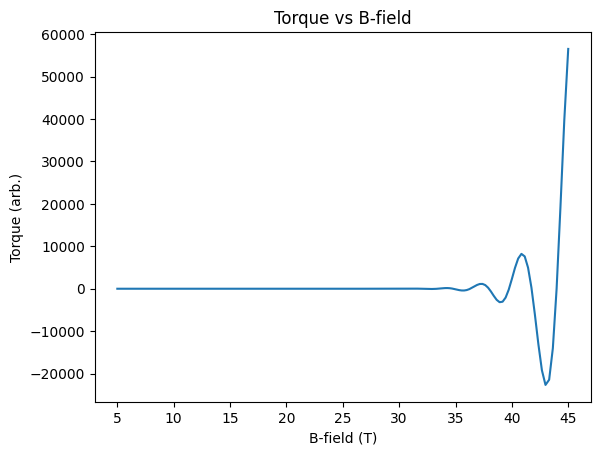

In [23]:
# now holding the angle constant and varying the B-field
B_vals, torque = qo.torque_simulation.B_sweep(
    df_interp,
    B_range = (5,45),
    angle = df_interp['angle'].unique()[10],
    T = 10,
    T_D = 2,
    phi_B = 0
)

plt.plot(B_vals, torque)
plt.xlabel('B-field (T)')
plt.ylabel('Torque (arb.)')
plt.title('Torque vs B-field')
plt.show()

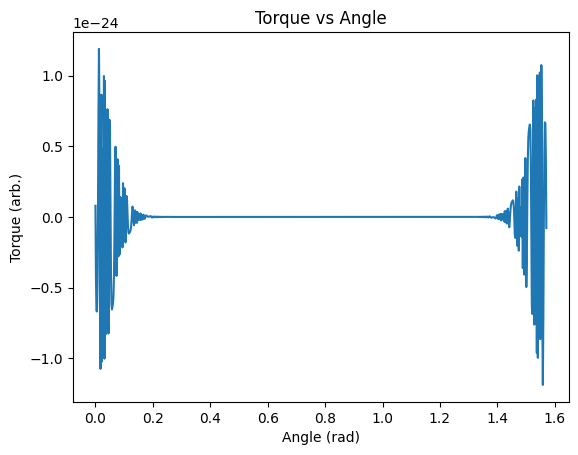

In [24]:
# now holding the B-field constant and varying the angle
angle_vals, torque = qo.torque_simulation.angle_sweep(
    df_interp,
    B = 10,
    T = 10,
    T_D = 2,
    phi_B = 0
)

plt.plot(angle_vals, torque)
plt.xlabel('Angle (rad)')
plt.ylabel('Torque (arb.)')
plt.title('Torque vs Angle')
plt.show()

### Torque FFT

In [25]:
freqs, amps, torques, angles = qo.torque_simulation.torque_fft_multi_angle(df, angle_step=1, B_range = (5,45))

In [26]:
torques.shape, freqs.shape, amps.shape

((16, 2048), (16, 1025), (16, 1025))

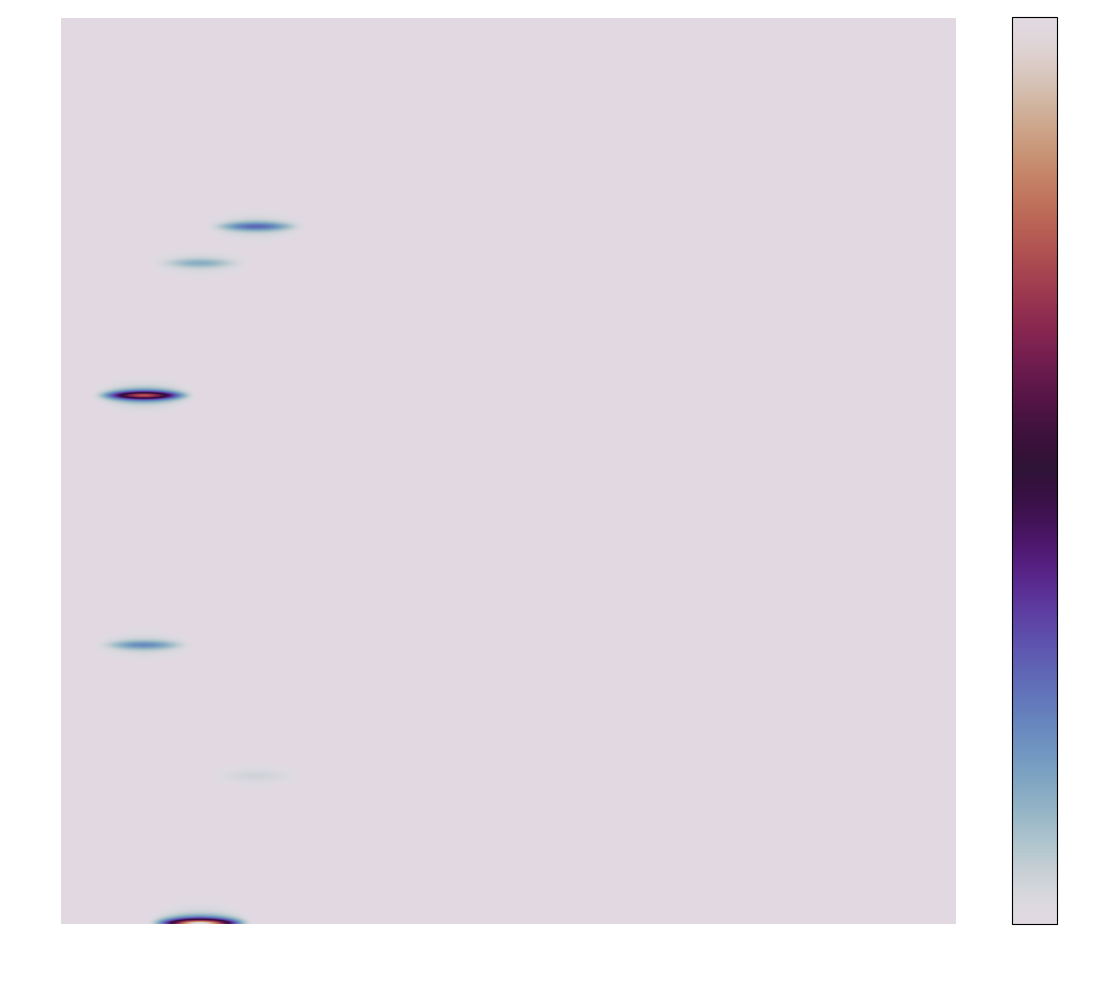

In [27]:
qo.torque_simulation.plot_fft_heatmap(freqs, amps, angles)